# Titanic: Machine Learning from Disaster

In [156]:
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
# from keras.utils.np_utils import normalize

from utils import *

In [162]:
train = pd.read_csv('kg-data/train.csv')
train.shape

(891, 12)

In [163]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [167]:
def normalize(df):
#     return (df - df.mean()) / df.std()
    return (df - df.min()) / (df.max() - df.min())

def extract_features(df):
    X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]

    X.loc[:, 'Sex'] = X['Sex'].factorize()[0]

#     X.loc[:, 'Cabin'] = X['Cabin'].factorize()[0]
    X['HasCabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    
    X.loc[:, 'Embarked'] = X['Embarked'].factorize()[0]
    
    X.loc[:, 'FamilySize'] = df['SibSp'] + df['Parch'] + 1

    X['IsAlone'] = 0
    X.loc[X['FamilySize'] == 1, 'IsAlone'] = 1

    X.loc[:, 'Age'] = X['Age'].fillna(0)
#     X.loc[:, 'Age'] = normalize(X['Age'].values)

    X.loc[:, 'Fare'] = X['Fare'].fillna(0)    
#     X.loc[:, 'Fare'] = normalize(X['Fare'].values)    
    
    if 'Survived' in df.columns:
        Y = df['Survived']
        return X, Y
    return X, None

X, Y = extract_features(train)

X.head()

/Users/dkostyshyn/workspace/jpnb/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/dkostyshyn/workspace/jpnb/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Pclass,Sex,Age,Fare,Embarked,HasCabin,FamilySize,IsAlone
0,3,0,22.0,7.2500,0,0,2,0
1,1,1,38.0,71.2833,1,1,2,0
2,3,1,26.0,7.9250,0,0,1,1
3,1,1,35.0,53.1000,0,1,2,0
4,3,0,35.0,8.0500,0,0,1,1


In [168]:
X = X.values
Y = Y.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
print('train/test: %d/%d' % (len(X_train), len(X_test)))

X_fet_len = X_train.shape[1]

train/test: 712/179


## Shallow model

In [169]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [170]:
# model = SVC(kernel='linear', gamma='auto', C=0.1)
# model = SVC(kernel='poly', degree=6, gamma='auto')
model = SVC(kernel='rbf', gamma='auto')
# model = SVC(kernel='sigmoid', gamma='auto')
model.fit(X_train, Y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [171]:
Y_pred = model.predict(X_test)

In [172]:
print(confusion_matrix(Y_test, Y_pred))  
print(classification_report(Y_test, Y_pred))

[[95 20]
 [28 36]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       115
           1       0.64      0.56      0.60        64

    accuracy                           0.73       179
   macro avg       0.71      0.69      0.70       179
weighted avg       0.73      0.73      0.73       179



## Deep model

In [147]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, AveragePooling2D, Dropout
from keras.models import load_model

In [148]:
def MyModel_v1():
    features = Input(shape=(X_fet_len, ), dtype='float32')
    X = Dense(20, activation='relu')(features)
    X = Dense(20, activation='relu')(X)
    X = Dense(1, activation='sigmoid', kernel_initializer='random_normal')(X)
    model = Model(inputs=features, outputs=X)
    return model

In [149]:
del model

In [150]:
model = MyModel_v1()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                180       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


In [151]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [159]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=8, validation_split=0.1)

Train on 640 samples, validate on 72 samples
Epoch 1/20
640/640 [==============================] - 0s 142us/step - loss: 0.4379 - acc: 0.8063 - val_loss: 0.5101 - val_acc: 0.7361
Epoch 2/20
640/640 [==============================] - 0s 136us/step - loss: 0.4364 - acc: 0.8234 - val_loss: 0.5084 - val_acc: 0.7361
Epoch 3/20
640/640 [==============================] - 0s 141us/step - loss: 0.4349 - acc: 0.8094 - val_loss: 0.5135 - val_acc: 0.7361
Epoch 4/20
640/640 [==============================] - 0s 137us/step - loss: 0.4356 - acc: 0.8156 - val_loss: 0.5118 - val_acc: 0.7639
Epoch 5/20
640/640 [==============================] - 0s 134us/step - loss: 0.4364 - acc: 0.8031 - val_loss: 0.5163 - val_acc: 0.7639
Epoch 6/20
640/640 [==============================] - 0s 134us/step - loss: 0.4361 - acc: 0.8109 - val_loss: 0.5188 - val_acc: 0.7361
Epoch 7/20
640/640 [==============================] - 0s 139us/step - loss: 0.4358 - acc: 0.8187 - val_loss: 0.5210 - val_acc: 0.7361
Epoch 8/20
640/64

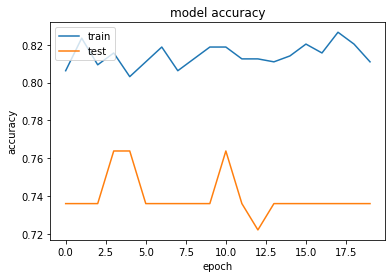

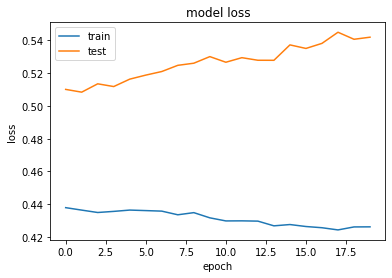

In [160]:
plot_model_accuracy(history)
plot_model_loss(history)

In [155]:
loss, acc = model.evaluate(X_test, Y_test)
print("Test loss = ", loss)
print("Test accuracy = ", acc)

179/179 [==============================] - 0s 30us/step
Test loss =  0.41394796634519565
Test accuracy =  0.8212290532762112


## Submission

In [139]:
sub_test = pd.read_csv('kg-data/test.csv', sep=',')
sub_test.shape

(418, 11)

In [140]:
sub_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [141]:
X_sub_test, _ = extract_features(sub_test)

/Users/dkostyshyn/workspace/jpnb/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dkostyshyn/workspace/jpnb/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/dkostyshyn/workspace/jpnb/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [142]:
Y_sub_pred = model.predict(X_sub_test)

In [110]:
# keras
Y_sub_pred = model.predict(X_sub_test).flatten()
Y_sub_pred = (Y_sub_pred >= 0.5).astype(int)

In [143]:
ids = sub_test['PassengerId']
labels = pd.Series(Y_sub_pred, name="Survived")
submission = pd.concat([ids, labels], axis=1)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [144]:
submission.to_csv('kg-data/submission.csv', sep=',', index=False)

## Kaggle

In [ ]:
!kaggle competitions download -c titanic -p 'kg-data'

In [145]:
!kaggle competitions submit -c titanic -f 'kg-data/submission.csv' -m 'New features, SVC'

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 24.5kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster